<a href="https://colab.research.google.com/github/DA-EUN00/DA-EUN00.github.io/blob/master/AI%20Art/style_transfer_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

아래 주소의 코드를 변형하여 사용했습니다.

https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko


In [179]:
#드라이브 사용한다고 선언
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 설정

### 모듈 구성 및 임포트

In [217]:
import tensorflow as tf

In [218]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [219]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

이미지를 다운로드받고 스타일 참조 이미지와 콘텐츠 이미지를 선택합니다:

## 입력 시각화

이미지를 불러오는 함수를 정의하고, 최대 이미지 크기를 512개의 픽셀로 제한합니다.

In [183]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

이미지를 출력하기 위한 간단한 함수를 정의합니다:

In [184]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

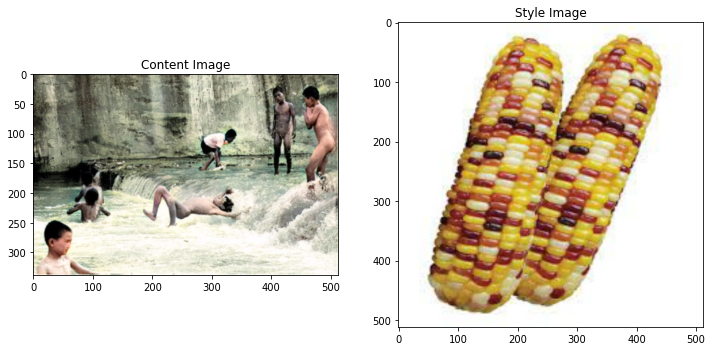

In [185]:
#만약 이미지를 주소로 가져올 경우 
# _path=tf.keras.utils.get_file('그림 이름.jpg', '그림url')
#그림 url은 마우스 우클릭-> 새탭에서 이미지 열기->새탭의 주소 복사

content_path ='/content/drive/MyDrive/AI Art/input photo_color/복구 사진/img_60d1da3232b34_deolify.png'
style_path='/content/drive/MyDrive/AI Art/Image/옥수수2.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## TF-Hub를 통한 빠른 스타일 전이

앞서 언급했듯이, 본 튜토리얼은 이미지 콘텐츠를 특정 스타일에 맞춰 최적화시키는 기존의 스타일 전이 알고리즘을 소개합니다. 이에 대해 살펴보기 전에, [텐서플로 허브](https://tensorflow.org/hub) 모듈은 어떤 결과물을 생성하는지 시험해봅시다:

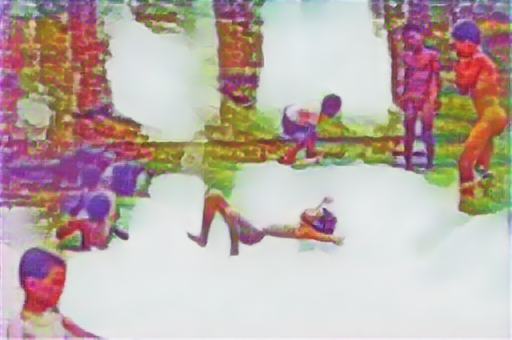

In [186]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## 콘텐츠와 스타일 표현 정의하기

이미지의 콘텐츠와 스타일 표현(representation)을 얻기 위해, 모델의 몇 가지 중간층들을 살펴볼 것입니다. 모델의 입력층부터 시작해서, 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응합니다. 반면, 네트워크가 깊어지면 최종 몇 개의 층은 *바퀴*나 *눈*과 같은 고차원적 특성들을 나타냅니다. 이번 경우, 우리는 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용할 것입니다. 이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요합니다. 입력 이미지가 주어졌을때, 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 해당하는 타깃 표현들을 일치시키려고 시도할 것입니다.


[VGG19](https://keras.io/applications/#vgg19) 모델을 불러오고, 작동 여부를 확인하기 위해 이미지에 적용시켜봅시다:

In [187]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [188]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('swimming_trunks', 0.6381154),
 ('fountain', 0.10707881),
 ('bikini', 0.0816283),
 ('cliff', 0.028730024),
 ('maillot', 0.021344824)]

이제 분류층을 제외한 `VGG19` 모델을 불러오고, 각 층의 이름을 출력해봅니다.

In [189]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_18
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간층들을 선택합니다:


In [190]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### 스타일과 콘텐츠를 위한 중간층

그렇다면 사전훈련된 이미지 분류 네트워크 속에 있는 중간 출력으로 어떻게 스타일과 콘텐츠 표현을 정의할 수 있을까요?

고수준에서 보면 (네트워크의 훈련 목적인) 이미지 분류를 수행하기 위해서는 네트워크가 반드시 이미지를 이해햐야 합니다. 이는 미가공 이미지를 입력으로 받아 픽셀값들을 이미지 내에 존재하는 특성(feature)들에 대한 복합적인 이해로 변환할 수 있는 내부 표현(internal representation)을 만드는 작업이 포함됩니다.

또한 부분적으로 왜 합성곱(convolutional) 신경망의 일반화(generalize)가 쉽게 가능한지를 나타냅니다. 즉, 합성곱 신경망은 배경잡음(background noise)과 기타잡음(nuisances)에 상관없이 (고양이와 강아지와 같이)클래스 안에 있는 불변성(invariance)과 특징을 포착할 수 있습니다. 따라서 미가공 이미지의 입력과 분류 레이블(label)의 출력 중간 어딘가에서 모델은 복합 특성(complex feature) 추출기의 역할을 수행합니다. 그러므로, 모델의 중간층에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 추출할 수 있습니다.

## 모델 만들기 

`tf.keras.applications`에서 제공하는 모델들은 케라스 함수형 API을 통해 중간층에 쉽게 접근할 수 있도록 구성되어있습니다.

함수형 API를 이용해 모델을 정의하기 위해서는 모델의 입력과 출력을 지정합니다:

`model = Model(inputs, outputs)`

아래의 함수는 중간층들의 결과물을 배열 형태로 출력하는 `VGG19` 모델을 반환합니다:

In [191]:
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

위 함수를 이용해 모델을 만들어봅시다:

In [192]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 512, 512, 64)
  최솟값:  0.0
  최댓값:  876.13245
  평균:  36.713085

block2_conv1
  크기:  (1, 256, 256, 128)
  최솟값:  0.0
  최댓값:  3544.3354
  평균:  189.73102

block3_conv1
  크기:  (1, 128, 128, 256)
  최솟값:  0.0
  최댓값:  11349.789
  평균:  175.71848

block4_conv1
  크기:  (1, 64, 64, 512)
  최솟값:  0.0
  최댓값:  12756.292
  평균:  608.76917

block5_conv1
  크기:  (1, 32, 32, 512)
  최솟값:  0.0
  최댓값:  2015.5962
  평균:  41.245575



## 스타일 계산하기

이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현됩니다.

이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다. 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다. 주어진 층에 대한 그람 행렬은 다음과 같이 계산할 수 있습니다:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

이 식은 `tf.linalg.einsum` 함수를 통해 쉽게 계산할 수 있습니다:

In [193]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 스타일과 콘텐츠 추출하기


스타일과 콘텐츠 텐서를 반환하는 모델을 만듭시다.

In [194]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

이미지가 입력으로 주어졌을때, 이 모델은 `style_layers`의 스타일과 `content_layers`의 콘텐츠에 대한 그람 행렬을 출력합니다:

In [195]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())


스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.023492318
    최댓값:  61974.65
    평균:  406.4062

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  86334.33
    평균:  15293.758

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  225258.08
    평균:  12918.957

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  3149262.2
    평균:  191940.11

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  132177.38
    평균:  2027.6053

콘텐츠:
   block5_conv2
    크기:  (1, 21, 32, 512)
    최솟값:  0.0
    최댓값:  1948.4413
    평균:  16.725893


## 경사하강법 실행

이제 스타일과 콘텐츠 추출기를 사용해 스타일 전이 알고리즘을 구현할 차례입니다. 타깃에 대한 입력 이미지의 평균 제곱 오차를 계산한 후, 오차값들의 가중합을 구합니다.

스타일과 콘텐츠의 타깃값을 지정합니다:

In [196]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

최적화시킬 이미지를 담을 `tf.Variable`을 정의하고 콘텐츠 이미지로 초기화합니다. (이때 `tf.Variable`는 콘텐츠 이미지와 크기가 같아야 합니다.):

In [197]:
image = tf.Variable(content_image)

픽셀 값이 실수이므로 0과 1 사이로 클리핑하는 함수를 정의합니다:

In [198]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

옵티마이저를 생성합니다. 참조 연구에서는 LBFGS를 추천하지만, `Adam`도 충분히 적합합니다:

In [199]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

최적화를 진행하기 위해, 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의합니다:

In [200]:
style_weight=1e-2
content_weight=1e4

In [201]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

`tf.GradientTape`를 사용해 이미지를 업데이트합니다.

In [202]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

구현한 알고리즘을 시험해보기 위해 몇 단계를 돌려봅시다:

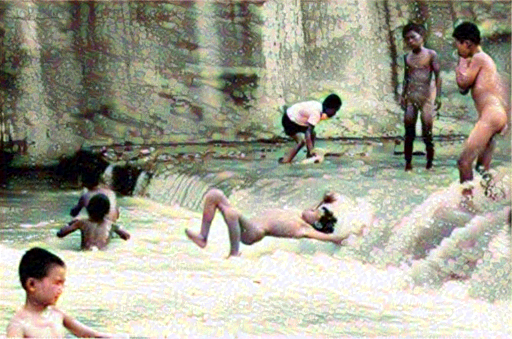

In [203]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

잘 작동하는 것을 확인했으니, 더 오랫동안 최적화를 진행해봅니다:

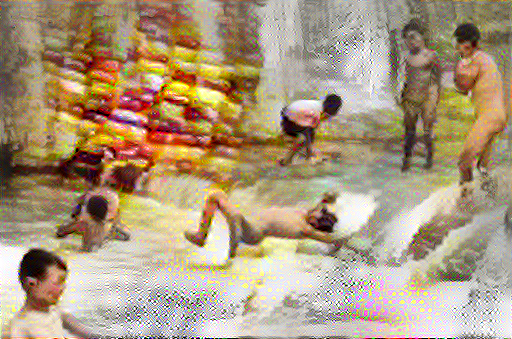

훈련 스텝: 1000
전체 소요 시간: 228.2


In [204]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))
  
end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

## 총 변위 손실

이 기본 구현 방식의 한 가지 단점은 많은 고주파 아티팩(high frequency artifact)가 생겨난다는 점 입니다. 아티팩 생성을 줄이기 위해서는 이미지의 고주파 구성 요소에 대한 레귤러리제이션(regularization) 항을 추가해야 합니다. 스타일 전이에서는 이 변형된 오차값을 *총 변위 손실(total variation loss)*라고 합니다:

In [205]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

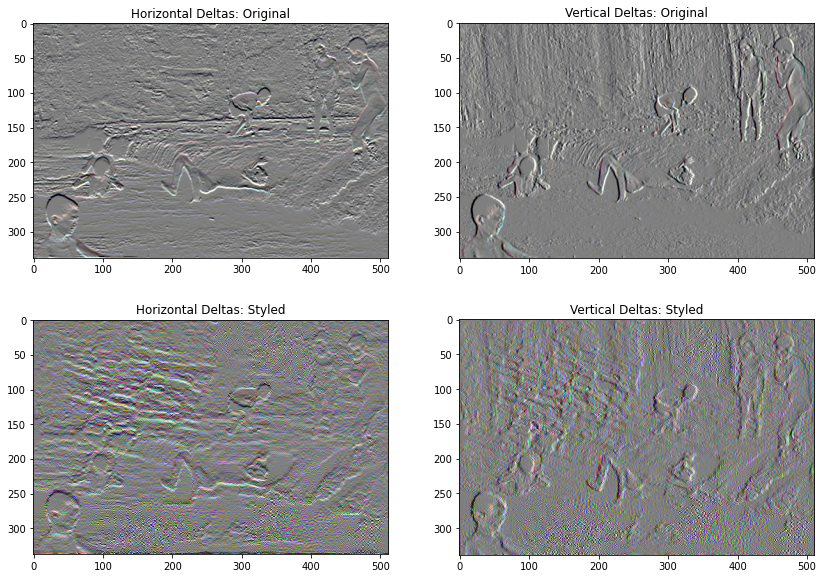

In [206]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

위 이미지들은 고주파 구성 요소가 늘어났다는 것을 보여줍니다.

한 가지 흥미로운 사실은 고주파 구성 요소가 경계선 탐지기의 일종이라는 점입니다. 이를테면 소벨 경계선 탐지기(Sobel edge detector)를 사용하면 유사한 출력을 얻을 수 있습니다:

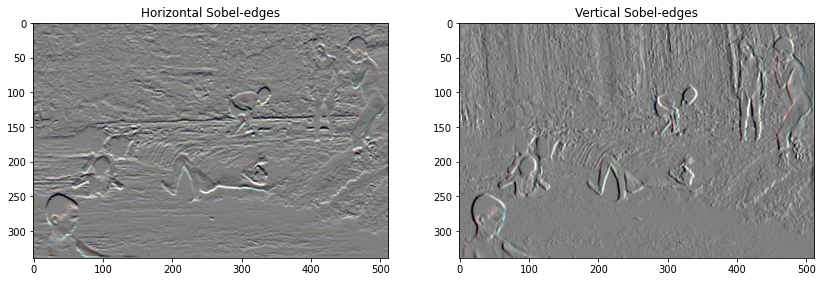

In [207]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

정규화 오차는 각 값의 절대값의 합으로 표현됩니다:

In [208]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [209]:
total_variation_loss(image).numpy()

88701.47

식이 잘 계산된다는 것을 확인할 수 있습니다. 하지만 다행히도 텐서플로에는 이미 표준 함수가 내장되어 있기 직접 오차식을 구현할 필요는 없습니다:

In [210]:
tf.image.total_variation(image).numpy()

array([88701.47], dtype=float32)

## 다시 최적화하기

`total_variation_loss`를 위한 가중치를 정의합니다:

In [211]:
total_variation_weight=30

이제 이 가중치를 `train_step` 함수에서 사용합니다:

In [212]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

최적화할 변수를 다시 초기화합니다:

In [213]:
image = tf.Variable(content_image)

최적화를 수행합니다:

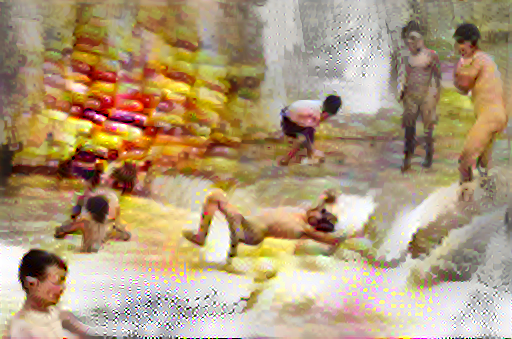

훈련 스텝: 1000
전체 소요 시간: 230.1


In [214]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

마지막으로, 결과물을 저장합니다:

In [216]:
file_name = 'stylized-image.png' #파일 이름
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>